In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
notebook_path = Path().resolve()
base_dir = notebook_path.parent / "data" / "covid_processed"

train_dir = base_dir / "train"
val_dir = base_dir / "val"
test_dir = base_dir / "test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 16930 images belonging to 4 classes.
Found 2115 images belonging to 4 classes.


In [4]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base_model.trainable = False  # Freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(train_gen.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2026-01-20 01:48:59.522381: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2026-01-20 01:48:59.522401: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2026-01-20 01:48:59.522404: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2026-01-20 01:48:59.522416: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-20 01:48:59.522423: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [5]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)

Epoch 1/10


2026-01-20 01:49:02.064525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


530/530 ━━━━━━━━━━━━━━━━━━━━ 98s 179ms/step - accuracy: 0.4799 - loss: 1.2030 - val_accuracy: 0.4818 - val_loss: 1.2058
Epoch 2/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 99s 187ms/step - accuracy: 0.4805 - loss: 1.1984 - val_accuracy: 0.4818 - val_loss: 1.1975
Epoch 3/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 131s 247ms/step - accuracy: 0.4815 - loss: 1.1952 - val_accuracy: 0.4818 - val_loss: 1.1882
Epoch 4/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 138s 260ms/step - accuracy: 0.4781 - loss: 1.1962 - val_accuracy: 0.4818 - val_loss: 1.1908
Epoch 5/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 142s 267ms/step - accuracy: 0.4815 - loss: 1.1942 - val_accuracy: 0.4818 - val_loss: 1.1897
Epoch 6/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 144s 271ms/step - accuracy: 0.4799 - loss: 1.1945 - val_accuracy: 0.4818 - val_loss: 1.1932
Epoch 7/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 146s 276ms/step - accuracy: 0.4779 - loss: 1.1969 - val_accuracy: 0.4818 - val_loss: 1.1941
Epoch 8/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 151s 284ms/step - accuracy: 0.4803 - loss: 1.1950

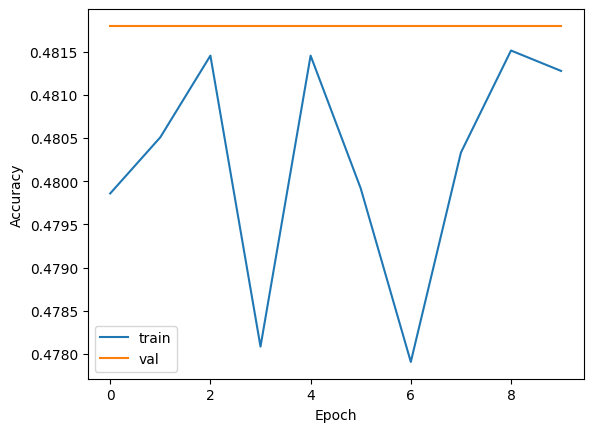

In [6]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [7]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

loss, acc = model.evaluate(test_gen)
print(f"Test Accuracy: {acc*100:.2f}%")

Found 2120 images belonging to 4 classes.
67/67 ━━━━━━━━━━━━━━━━━━━━ 14s 203ms/step - accuracy: 0.4811 - loss: 1.1928
Test Accuracy: 48.11%


In [8]:
model.save("../backend/models/EfficientNetB0_covid.h5")